# Twitter Sentiment Analysis

This notebook will introduce you to the concept of sentiment analysis in Python

Competition: [Kaggle Competition](https://www.kaggle.com/c/twitter-sentiment-analysis2/)

Getting started with the Kaggle API: [API](https://github.com/Kaggle/kaggle-api)

To learn how the Naive Bayes classifier works: [Jurafsky](https://web.stanford.edu/~jurafsky/slp3/4.pdf)

Other interesting NLP datasets: [NLP Datasets](https://lionbridge.ai/datasets/top-20-twitter-datasets-for-natural-language-processing-and-machine-learning/)

To keep up with the latest research: [NLP Progress](https://nlpprogress.com/)

We will cover:

0. [Install Packages & Download Data](#0-Install-Packages-&-Download-Data)
1. [Importing Libraries](#1.-Importing-Libraries)
2. [Loading Data](#2.-Loading-Data)
3. [Exploratory Data Analysis](#3.-EDA)
4. [Data Preprocessing](#4.-Data-Preprocessing)
5. [Model Training and Evaluation](#5.-Model-Training-and-Evaluation)
    1. [Naive Bayes Classifier](#Naive-Bayes-Classifier-link)
    2. [SVM](#SVM-link)
6. [Model Evaluation](#6.-Model-Evaluation-F1-Score)

Visit [Kaggle notebooks on this challenge](https://www.kaggle.com/crowdflower/twitter-airline-sentiment/notebooks) to see more solutions and how to perform feature extraction. 

## 0. Install Packages & Download Data

In [78]:
# !kaggle datasets download crowdflower/twitter-airline-sentiment
# !pip install wordcloud
# !pip install seaborn

# import nltk
# nltk.download('stopwords')

## 1. Importing Libraries

In [1]:
import string

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score

from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

## 2. Loading Data

In [2]:
complete_data = pd.read_csv('twitter-airline-sentiment/Tweets.csv')
complete_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

**We have a lot of data that will not be useful for our analysis. Let's filter it to data that is useful for us.**

In [4]:
# data we need
data = complete_data[["airline_sentiment", "text", "airline", "negativereason"]]
data.head()

,airline_sentiment,text,airline,negativereason
0,neutral,@VirginAmerica What @dhepburn said.,Virgin America,NaN
1,positive,@VirginAmerica plus you've added commercials t...,Virgin America,NaN
2,neutral,@VirginAmerica I didn't today... Must mean I n...,Virgin America,NaN
3,negative,@VirginAmerica it's really aggressive to blast...,Virgin America,Bad Flight
4,negative,@VirginAmerica and it's a really big bad thing...,Virgin America,Can't Tell


## 3. EDA

### Sentiment count distribution

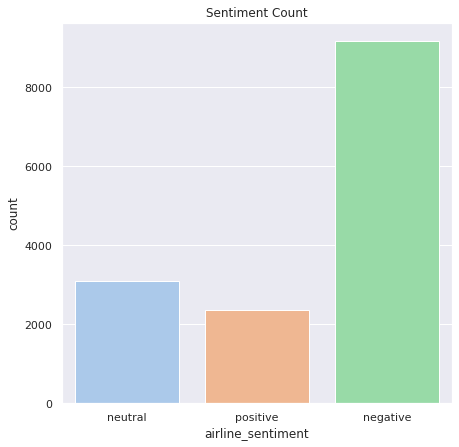

In [5]:
# get count of sentiment classes
sns.set()      # to set theme
plt.figure(figsize=(7,7))
sns.countplot(x=data["airline_sentiment"],palette="pastel")
plt.title("Sentiment Count")
plt.show()

> Many people are unhappy with airlines.

### Word Cloud for the Classes

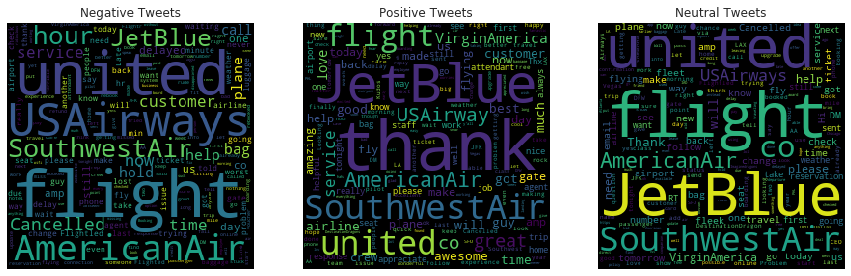

In [6]:
# Append tweets to strings
negative = " ".join(data[data['airline_sentiment'] == 'negative']['text'].to_list())
positive = " ".join(data[data['airline_sentiment'] == 'positive']['text'].to_list())
neutral = " ".join(data[data['airline_sentiment'] == 'neutral']['text'].to_list())

fig, ax = plt.subplots(1, 3, figsize=(15,15))

# https://pypi.org/project/wordcloud/
neg_wordcloud = WordCloud(width=256, height=256, stopwords = STOPWORDS, collocations=False).generate(negative)
pos_wordcloud = WordCloud(width=256, height=256, stopwords = STOPWORDS, collocations=False).generate(positive)
neutral_wordcloud = WordCloud(width=256, height=256, stopwords = STOPWORDS, collocations=False).generate(neutral)
word_clouds = [neg_wordcloud, pos_wordcloud, neutral_wordcloud]
titles = ["Negative Tweets", "Positive Tweets", "Neutral Tweets"]

for num, el in enumerate(word_clouds):
    ax[num].imshow(el)
    ax[num].axis('off')
    ax[num].set_title(titles[num])

### Reasons why people post negative tweets

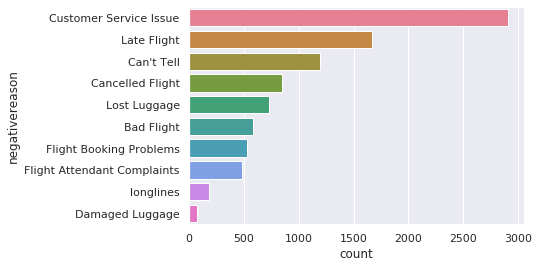

In [7]:
ax0 = sns.countplot(y = data['negativereason'], 
                    palette="husl", 
                    order = complete_data.negativereason.value_counts().index)

### More exploration ideas
1. *No of tweets per airline*
2. *Sentiment distribution per airline*

## 4. Data Preprocessing

### Transform sentiment to number [Label Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [8]:
# each label is assigned a unique integer based on alphabetical ordering
encoder = LabelEncoder()
data["airline_sentiment"] = encoder.fit_transform(data["airline_sentiment"])
print(encoder.classes_)
data.head()

['negative' 'neutral' 'positive']


,airline_sentiment,text,airline,negativereason
0,1,@VirginAmerica What @dhepburn said.,Virgin America,NaN
1,2,@VirginAmerica plus you've added commercials t...,Virgin America,NaN
2,1,@VirginAmerica I didn't today... Must mean I n...,Virgin America,NaN
3,0,@VirginAmerica it's really aggressive to blast...,Virgin America,Bad Flight
4,0,@VirginAmerica and it's a really big bad thing...,Virgin America,Can't Tell


### Stop word and punctuation removal
*Words will be converted to lowercase in Vectorize function*

In [9]:
stop_words = stopwords.words('english')
stop_words += list(string.punctuation)

### More pre-processing

1. *Remove user tagging (begin with @) and hashtags (begin with #)*

### Split data into train and test data

In [10]:
X = data['text'].values
y = data['airline_sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [11]:
len(X), len(X_train), len(X_test)

(14640, 9808, 4832)

### Vectorize tweets [link](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [12]:
# by default converts words to lowercase
# dictionary built - top 4000 words
# remove stop words
# use unigram to trigrams
# ignore corpus specific words - max_df

cv = CountVectorizer(max_features = 4000,
                     stop_words = stop_words,
                     analyzer = 'word',  
                     ngram_range = (1,3), 
                     max_df = 0.8)

In [13]:
X_train_vec = cv.fit_transform(X_train)
X_test_vec  = cv.transform(X_test)

In [14]:
print('Train: ', X_train_vec.shape)
print('Test: ', X_test_vec.shape)
y_train

Train:  (9808, 4000)
Test:  (4832, 4000)


array([0, 0, 0, ..., 0, 0, 0])

## 5. Model Training and Evaluation

### Naive Bayes Classifier [link](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In [15]:
# Train model
NB_classifer = MultinomialNB(alpha = 0.1)    # alpha - smoothing
NB_classifer.fit(X_train_vec, y_train)

# Test accuracy
nb_accuracy = NB_classifer.score(X_test_vec, y_test)
print('NB Accuracy: {}%'.format(nb_accuracy*100))

# Make predictions
y_predict = NB_classifer.predict(X_test_vec)
y_predicted_nb = list(encoder.inverse_transform(NB_classifer.predict(X_test_vec)))
NB_predictions = pd.DataFrame(zip(X_test, y_predicted_nb), columns=['Tweet', 'Prediction'])
NB_predictions.head()

# NB_predictions.to_csv('NB_pred.csv', index=False)

NB Accuracy: 77.04884105960265%


,Tweet,Prediction
0,@AmericanAir In car gng to DFW. Pulled over 1h...,negative
1,"@AmericanAir after all, the plane didn’t land ...",negative
2,@SouthwestAir can't believe how many paying cu...,negative
3,@USAirways I can legitimately say that I would...,negative
4,@AmericanAir still no response from AA. great ...,negative


### SVM [link](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [16]:
# Train model
svc = SVC(gamma = 'auto')
svc.fit(X_train_vec, y_train)

# Test Accuracy
svc_accuracy = svc.score(X_test_vec, y_test)
print('SVC Accuracy: {}%'.format(svc_accuracy*100))

# Make predictions
y_predicted_svc = list(encoder.inverse_transform(svc.predict(X_test_vec)))
svc_predictions = pd.DataFrame(zip(X_test, y_predicted_svc), columns=['Tweet', 'Prediction'])
svc_predictions.head()

# svc_predictions.to_csv('SVM_pred.csv', index=False)

SVC Accuracy: 63.100165562913915%


,Tweet,Prediction
0,@AmericanAir In car gng to DFW. Pulled over 1h...,negative
1,"@AmericanAir after all, the plane didn’t land ...",negative
2,@SouthwestAir can't believe how many paying cu...,negative
3,@USAirways I can legitimately say that I would...,negative
4,@AmericanAir still no response from AA. great ...,negative


## 6. Model Evaluation [F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

In [17]:
# Evaluate accuracy of NB Classifier using metrics that handle imbalance in data 
NB_f1 = f1_score(y_test, y_predict, average="micro")

print('NB F1 Score: {}%'.format(round(NB_f1*100, 2)))

NB F1 Score: 77.05%
